# Imports

notes:

scipy==1.12
gensim==4.3.1
numpy==1.22


In [2]:
%pip install -r requirements.txt

# Todo: NEED TO ADD SPELL CHECK

Note: you may need to restart the kernel to use updated packages.


In [3]:
#import kagglehub
import os
import shutil
import pandas as pd

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [5]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os


from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora


from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

import ssl
import certifi
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text  # This is necessary for ELMo
import numpy as np

import ssl
import certifi
import tensorflow_hub as hub

from collections import Counter


/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import pickle
import glob
import numpy as np

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



# 1. EDA and Data Wrangling 


## Load


In [ ]:
# download the data
# Download latest version
path = kagglehub.dataset_download("subhajeetdas/hate-comment")

print("Path to dataset files:", path)

destination_path = "/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data"
os.makedirs(destination_path, exist_ok=True)

# move downloaded files
for file in os.listdir(path):
    shutil.move(os.path.join(path, file), destination_path)

print("Dataset moved to:", destination_path)

In [9]:
data = pd.read_csv('/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data/hate.csv')

In [10]:
data.drop(columns=['0'], inplace=True)


In [11]:
data

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,Arabs are not welcome,N
3,I'm not saying we should actually eliminate he...,N
4,bananas are for black people,N
...,...,...
41139,Indian culture is so backwards,N
41140,"Women don't want equality, they just want to b...",N
41141,fuck covid,P
41142,This computer is garbage,P


/var/folders/zv/4f9cw9vs6tjbvz5bh2k07w_40000gn/T/ipykernel_85442/633069675.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Hateful", "Non Hateful", "Other"])


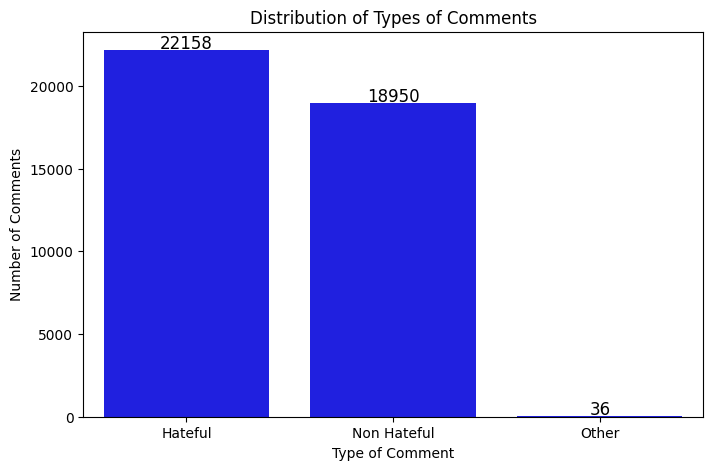

In [16]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data['label'].value_counts(), color="Blue")

# Labels and title
plt.xlabel("Type of Comment")
plt.ylabel("Number of Comments")
plt.title("Distribution of Types of Comments")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='Black', 
                xytext=(0, 5), textcoords='offset points')

# Customize x-axis labels
ax.set_xticklabels(["Hateful", "Non Hateful", "Other"])


# Show plot
plt.show()

## Data distribution

In [17]:
filtered_df = data[data['label'] == 'N']
filtered_df

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,Arabs are not welcome,N
3,I'm not saying we should actually eliminate he...,N
4,bananas are for black people,N
...,...,...
41136,Mandatory masks should be for mozzies only,N
41137,Women are dishonest,N
41139,Indian culture is so backwards,N
41140,"Women don't want equality, they just want to b...",N


N: gay people are a burden to our society

P(non hate): 
- this drink sucks, it's awful
- fuck covid

N(hate):
- gay people are a burden to our society
- Arabs are not welcome



## Cleaning

In [18]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def clean_comment(comment): 

    suggestions = sym_spell.lookup_compound(comment, max_edit_distance=2)

    for suggestion in suggestions:
        #print(suggestion.term)
        tokens = suggestion.term

    #split document into individual words
    tokens=tokens.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))

    # # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]

    # # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]

    # # filter out short tokens
    # tokens = [word for word in tokens if len(word) > 4]

    #lowercase all words
    tokens = [word.lower() for word in tokens]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]    

    # word stemming    
    ps=PorterStemmer()
    tokens=[ps.stem(word) for word in tokens]

    #print(tokens)
    return tokens


In [19]:
# Apply the clean_comment function to the 'comment' column
data['cleaned_comment'] = data['comment'].apply(clean_comment)

# Compute comment lengths after cleaning
data['comment_length'] = data['cleaned_comment'].apply(len)

# Get statistics
average_length = data['comment_length'].mean()
max_length = data['comment_length'].max()
min_length = data['comment_length'].min()

# Display results
print(f"Average Length: {average_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")


Average Length: 12.594764728757534
Max Length: 212
Min Length: 0


In [20]:

# Compute comment lengths

data['comment_length'] = data['comment'].apply(len)

# Get statistics
average_length = data['comment_length'].mean()
max_length = data['comment_length'].max()
min_length = data['comment_length'].min()

# Display results
print(f"Average Length: {average_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")


data['comment_length_clean'] = data['cleaned_comment'].apply(len)

# Get statistics
average_length = data['comment_length_clean'].mean()
max_length = data['comment_length_clean'].max()
min_length = data['comment_length_clean'].min()

# Display results
print(f"Average Length: {average_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")



Average Length: 134.29642232160217
Max Length: 2374
Min Length: 4
Average Length: 12.594764728757534
Max Length: 212
Min Length: 0


In [21]:
# want to stitch back together the cleaned_comment
data['cleaned_comment_string'] = data['cleaned_comment'].apply(lambda x: " ".join(x))

In [22]:
data

,comment,label,cleaned_comment,comment_length,comment_length_clean,cleaned_comment_string
0,dalits are lowlives,N,"[davit, lowlif]",19,2,davit lowlif
1,gay people are a burden to our society,N,"[gay, peopl, burden, societi]",38,4,gay peopl burden societi
2,Arabs are not welcome,N,"[arab, welcom]",21,2,arab welcom
3,I'm not saying we should actually eliminate he...,N,"[im, say, actual, elimin, herb, wish, natur, b...",93,9,im say actual elimin herb wish natur becam ext...
4,bananas are for black people,N,"[banana, black, peopl]",28,3,banana black peopl
...,...,...,...,...,...,...
41139,Indian culture is so backwards,N,"[indian, cultur, backward]",30,3,indian cultur backward
41140,"Women don't want equality, they just want to b...",N,"[women, dont, want, equal, want, charg]",57,6,women dont want equal want charg
41141,fuck covid,P,"[fuck, covid]",10,2,fuck covid
41142,This computer is garbage,P,"[comput, garbag]",24,2,comput garbag


In [23]:
data.to_csv('./data/hate_cleaned.csv', index=False)

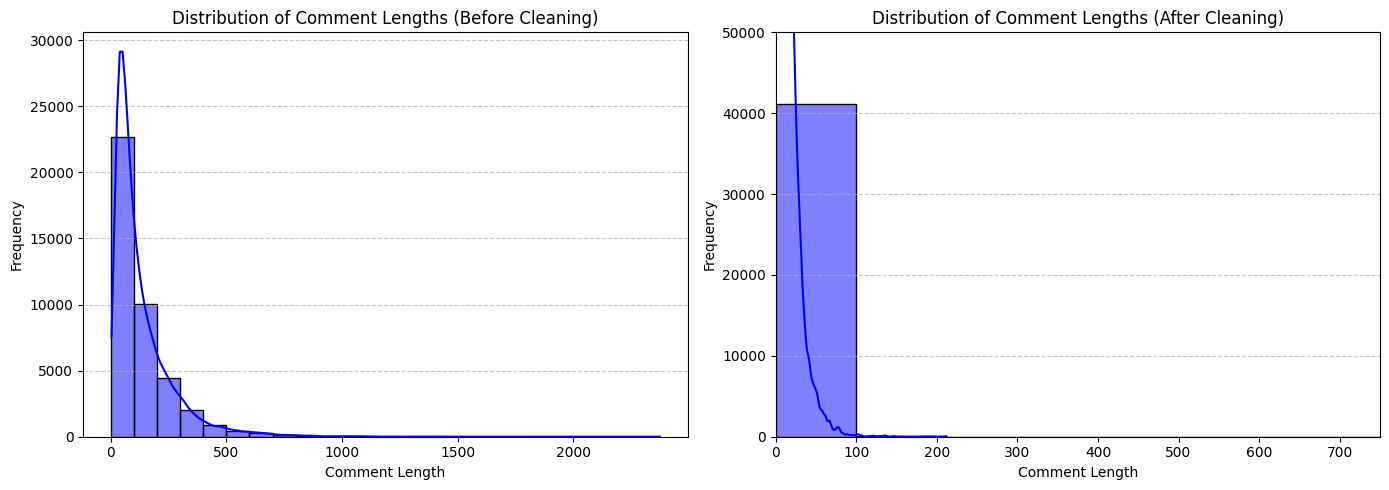

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# specify bins
bins = range(0, 2001, 100)  

# first hist
sns.histplot(data['comment_length'], bins=bins, kde=True, color='blue', ax=axes[0])
axes[0].set_xlabel("Comment Length")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Comment Lengths (Before Cleaning)")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# second hist
sns.histplot(data['comment_length_clean'], bins=bins, kde=True, color='blue', ax=axes[1])
axes[1].set_xlabel("Comment Length")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Comment Lengths (After Cleaning)")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.xlim(0, 750)
plt.ylim(0,50000)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


## Words

In [25]:
data

,comment,label,cleaned_comment,comment_length,comment_length_clean,cleaned_comment_string
0,dalits are lowlives,N,"[davit, lowlif]",19,2,davit lowlif
1,gay people are a burden to our society,N,"[gay, peopl, burden, societi]",38,4,gay peopl burden societi
2,Arabs are not welcome,N,"[arab, welcom]",21,2,arab welcom
3,I'm not saying we should actually eliminate he...,N,"[im, say, actual, elimin, herb, wish, natur, b...",93,9,im say actual elimin herb wish natur becam ext...
4,bananas are for black people,N,"[banana, black, peopl]",28,3,banana black peopl
...,...,...,...,...,...,...
41139,Indian culture is so backwards,N,"[indian, cultur, backward]",30,3,indian cultur backward
41140,"Women don't want equality, they just want to b...",N,"[women, dont, want, equal, want, charg]",57,6,women dont want equal want charg
41141,fuck covid,P,"[fuck, covid]",10,2,fuck covid
41142,This computer is garbage,P,"[comput, garbag]",24,2,comput garbag


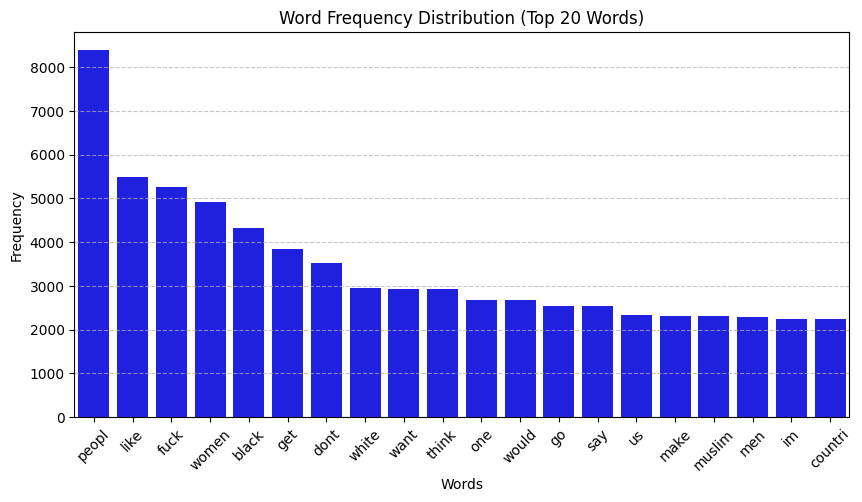

In [ ]:
# figure out the word count
filtered_words = [word for sublist in data['cleaned_comment'] for word in sublist]

# Count word frequencies
word_counts = Counter(filtered_words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# Sort by frequency
word_freq_df = word_freq_df.sort_values(by='count', ascending=False)
word_freq_df = word_freq_df.iloc[:20]

# Plot 
plt.figure(figsize=(10, 5))
sns.barplot(x=word_freq_df['word'], y=word_freq_df['count'], color='blue')

# Labels 
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Top 20 Words)")
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


# Clustering and Word Embeddings

## Clustering

In [31]:

"""
    Clusters word embeddings using KMeans with both PCA and t-sne dimension reduction

    Args:
        embeddings (np.array): Word embeddings (n_samples, n_features).
        n_clusters (int): Number of clusters for KMeans.

    Returns:
        dict: Cluster labels for KMeans 
"""

def cluster_embeddings(title, embeddings, n_clusters=2):

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(embeddings)

    # dimension reduction: TSNE
    reducer = TSNE(n_components=2, random_state=42, init = 'random')
    reduced_embeddings_tsne = reducer.fit_transform(embeddings)

    # dimension reduction: PCA
    reducer = PCA(n_components=2, random_state=42)
    reduced_embeddings_pca = reducer.fit_transform(embeddings)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.scatterplot(x=reduced_embeddings_tsne[:, 0], y=reduced_embeddings_tsne[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[0])
    axes[0].set_title(f"{title}: KMeans with tsne")

    sns.scatterplot(x=reduced_embeddings_pca[:, 0], y=reduced_embeddings_pca[:, 1], hue=kmeans_labels, palette="coolwarm", ax=axes[1])
    axes[1].set_title(f"{title}: KMeans with pca")

    plt.show()

    return {'kmeans_labels': kmeans_labels}




# 2. word emebeddings:
 - Word2Vec
 - GloVe
 - Elmo
 - Bert
 - TF-IDF
 

 Probably:
- make the max length 200 based on the histogram
- use word2vec
- TF-IDF
- work on seeing how elmo/other things work
- spell check?


## TF-IDF


In [35]:
Tfidf=TfidfVectorizer(ngram_range=(1,1))
TFIDF_embeddings=Tfidf.fit_transform(data['cleaned_comment_string'].tolist())     

tfidf_matrix_df=pd.DataFrame(TFIDF_embeddings.toarray(), columns=Tfidf.get_feature_names_out(), index=data['label'].tolist())

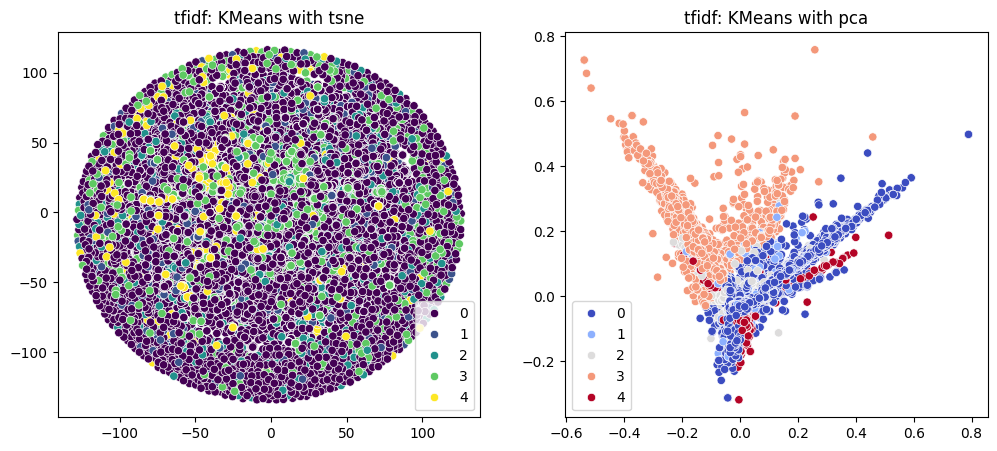

{'kmeans_labels': array([0, 3, 0, ..., 0, 0, 4], dtype=int32)}

In [36]:
cluster_embeddings("tfidf", TFIDF_embeddings, n_clusters=5)

## Doc2Vec

In [37]:
# set up documents
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['cleaned_comment'])]
model = Doc2Vec(documents, vector_size=50, window=2, min_count=1, workers=4)

# Train the model
model = Doc2Vec(vector_size=50, window=2, min_count=1, workers=4, epochs=20)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

# embeddings
doc2vec_embeddings = np.array([model.dv[i] for i in range(len(documents))])
            

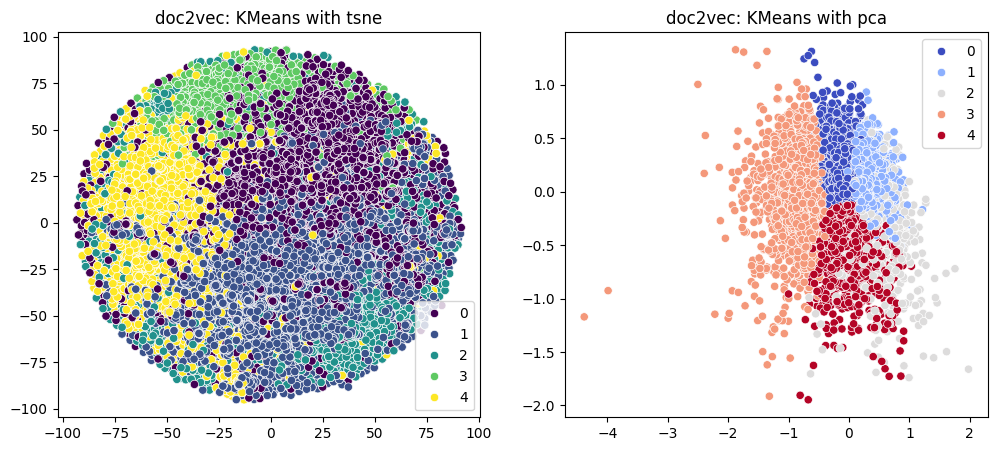

{'kmeans_labels': array([0, 0, 0, ..., 0, 0, 1], dtype=int32)}

In [38]:
cluster_embeddings("doc2vec",doc2vec_embeddings, n_clusters=5)

## Word2Vec

In [39]:
# Tokenize comments (assuming data['cleaned_comment'] contains lists of list of words)
tokenized_comments = data['cleaned_comment']

# Train  model 
w2v_model = Word2Vec(sentences=tokenized_comments, vector_size=100, window=5, min_count=1, workers=4)

# Function to compute sentence vector by averaging word vectors
def get_sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Convert all comments into vectors
word2vec_embeddings = np.array([get_sentence_vector(comment, w2v_model) for comment in tokenized_comments])



In [40]:
# Explore the word clusters

# Apply K-Means clustering
k = 5  # Number of clusters
km = KMeans(n_clusters=k, random_state=89)
clusters = km.fit_predict(word2vec_embeddings)

# Create df
data['Cluster'] = clusters
cluster_df = data[['Cluster', 'label', 'cleaned_comment']]

cluster_df

,Cluster,label,cleaned_comment
0,4,N,"[davit, lowlif]"
1,3,N,"[gay, peopl, burden, societi]"
2,0,N,"[arab, welcom]"
3,1,N,"[im, say, actual, elimin, herb, wish, natur, b..."
4,3,N,"[banana, black, peopl]"
...,...,...,...
41139,0,N,"[indian, cultur, backward]"
41140,3,N,"[women, dont, want, equal, want, charg]"
41141,2,P,"[fuck, covid]"
41142,4,P,"[comput, garbag]"


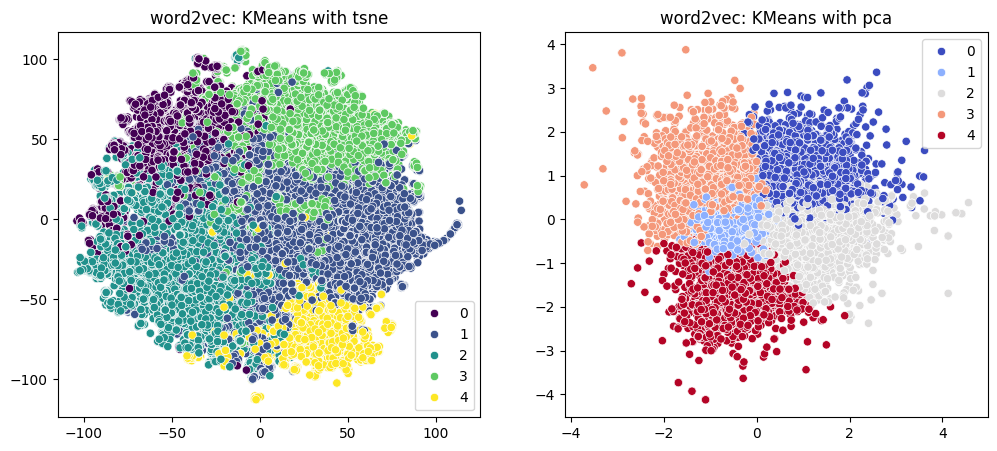

{'kmeans_labels': array([1, 0, 3, ..., 4, 1, 3], dtype=int32)}

In [41]:
cluster_embeddings("word2vec", word2vec_embeddings, n_clusters=5)

## BERT


In [42]:

# Load pre-trained BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast & efficient

# Convert comments to BERT embeddings
bert_embeddings = bert_model.encode(data['cleaned_comment_string'].tolist(), show_progress_bar=True)

# Normalize embeddings
bert_embeddings = StandardScaler().fit_transform(bert_embeddings)


Batches: 100%|██████████| 1286/1286 [01:17<00:00, 16.70it/s]


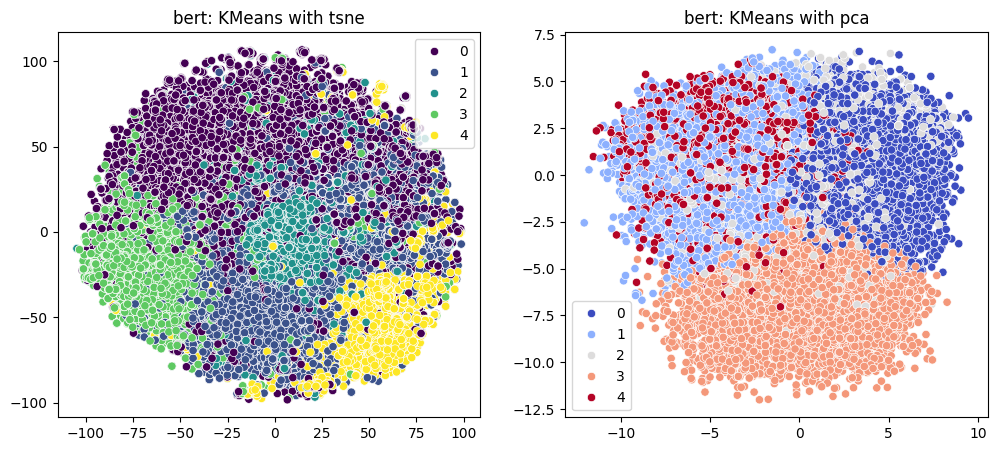

{'kmeans_labels': array([0, 1, 4, ..., 0, 0, 4], dtype=int32)}

In [43]:
cluster_embeddings("bert", bert_embeddings, n_clusters=5)

## Elmo

See the elmo.ipynb notebook for the elmo embeddings. Google colab GPU were used and saved intermediately

In [44]:
#  In GOOGLE COLAB

In [ ]:
import pickle

# Save embeddings to a pickle file in Google Drive
file = '/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data/Data_Results/elmo_embeddings_5000.pkl'

with open(file, 'rb') as f:
    elmo_embeddings = pickle.load(f)



In [60]:
# Average over tokens to get a single vector per comment
reduced_embeddings = elmo_embeddings.mean(axis=1)


Shape of reduced embeddings: (999, 1024)


In [49]:
def load_and_concatenate_pickles(file_pattern):
    all_embeddings = []
    
    # Find all pickle files matching the pattern
    file_paths = glob.glob(file_pattern)
    
    # Load multiple batches
    for file in file_paths:
        with open(file, 'rb') as f:
            elmo_embeddings = pickle.load(f)
            
            # Reduce each sample to a single vector by averaging over tokens
            reduced_embeddings = elmo_embeddings.mean(axis=1)

            # add to list
            all_embeddings.append(reduced_embeddings)
    
    # Concatenate into a single array
    concatenated_embeddings = np.concatenate(all_embeddings, axis=0)
    return concatenated_embeddings

# Example usage
file_pattern = '/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data/Data_Results_New_4/*.pkl'
elmo_embeddings = load_and_concatenate_pickles(file_pattern)


In [50]:
elmo_embeddings.shape

(41144, 1024)

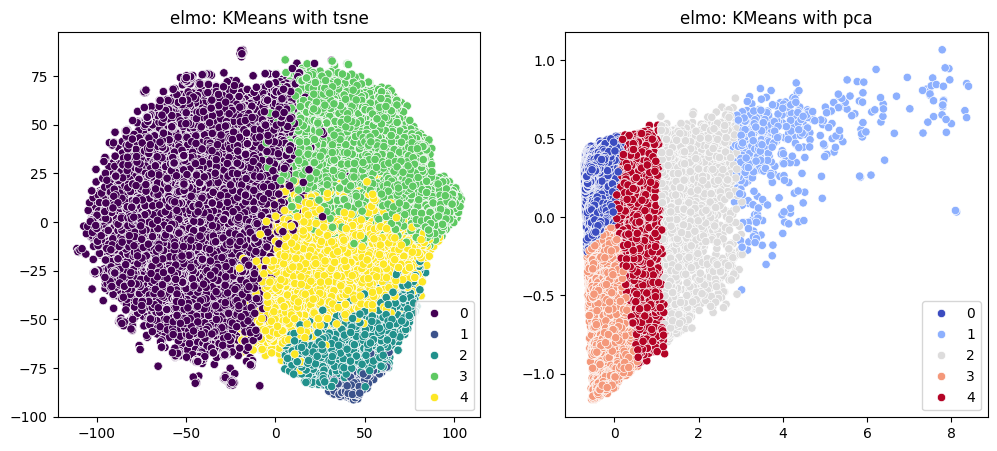

{'kmeans_labels': array([3, 3, 3, ..., 0, 0, 0], dtype=int32)}

In [51]:
cluster_embeddings("elmo", elmo_embeddings, n_clusters=5)

# 3. Classify:

In [47]:
def convert_labels(label):
    if label == 'N':
        return 1
    else:
        return 0

def classification_model(embedding_name, X, y):

    # Split into training and testing sets
    y = y.apply(convert_labels)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    plt.figure(figsize=(10, 8))

    # dict of models tested
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "kNN": KNeighborsClassifier(n_neighbors=5),
        "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42)
    }

    results = {}
    
    # loop over each model
    for name, model in models.items():
        
        # fit the model
        model.fit(X_train, y_train)

        # predict
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # assessment scores
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        
        results[name] = {
            'accuracy': acc,
            'auc': auc,
            'f1_score': f1,
            'fpr': fpr,
            'tpr': tpr
        }
        
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
        print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

    # Find the best model based on AUC
    best_model = max(results, key=lambda x: results[x]['auc'])
    best_fpr = results[best_model]['fpr']
    best_tpr = results[best_model]['tpr']
    best_f1 = results[best_model]['f1_score']
    
    print(f"\n{embedding_name}: Best Model: {best_model} (AUC = {results[best_model]['auc']:.4f})")

    # Plot ROC curves
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.title(f"{embedding_name}: ROC Curves: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # Return best model name, F1 score, FPR, and TPR
    return best_model, best_f1, best_fpr, best_tpr


Random Forest - Accuracy: 0.6138, AUC: 0.6787, F1: 0.6518
Gradient Boosting - Accuracy: 0.6606, AUC: 0.7011, F1: 0.6734
Logistic Regression - Accuracy: 0.6759, AUC: 0.7467, F1: 0.7029
kNN - Accuracy: 0.5219, AUC: 0.5110, F1: 0.6363
Decision Tree - Accuracy: 0.5643, AUC: 0.5769, F1: 0.7052

TFIDF: Best Model: Logistic Regression (AUC = 0.7467)


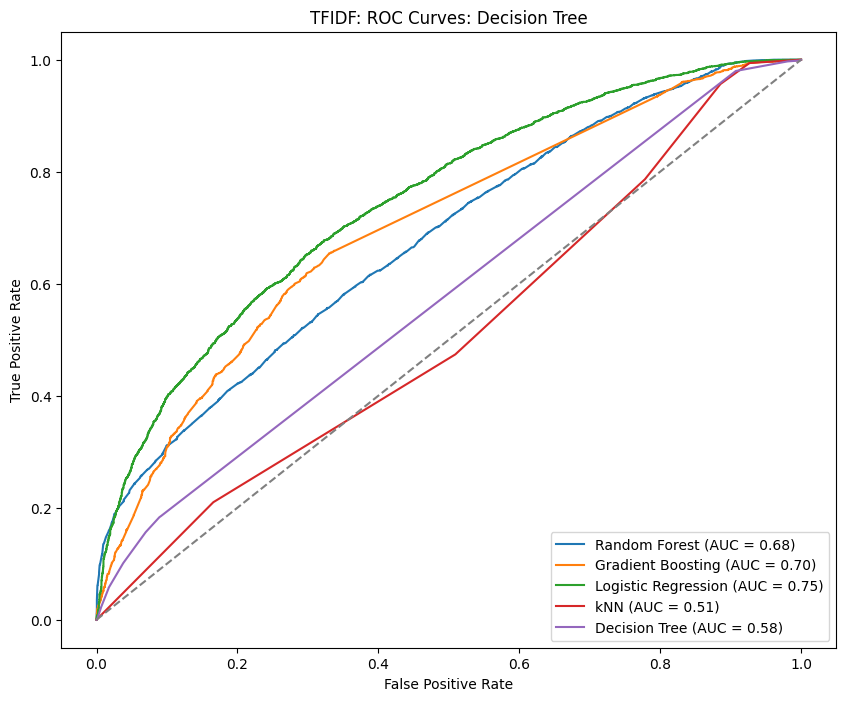

Random Forest - Accuracy: 0.5574, AUC: 0.6059, F1: 0.6087
Gradient Boosting - Accuracy: 0.6044, AUC: 0.6517, F1: 0.6562
Logistic Regression - Accuracy: 0.5914, AUC: 0.6328, F1: 0.6741
kNN - Accuracy: 0.5410, AUC: 0.5773, F1: 0.5821
Decision Tree - Accuracy: 0.5781, AUC: 0.6054, F1: 0.6383

doc2vec: Best Model: Gradient Boosting (AUC = 0.6517)


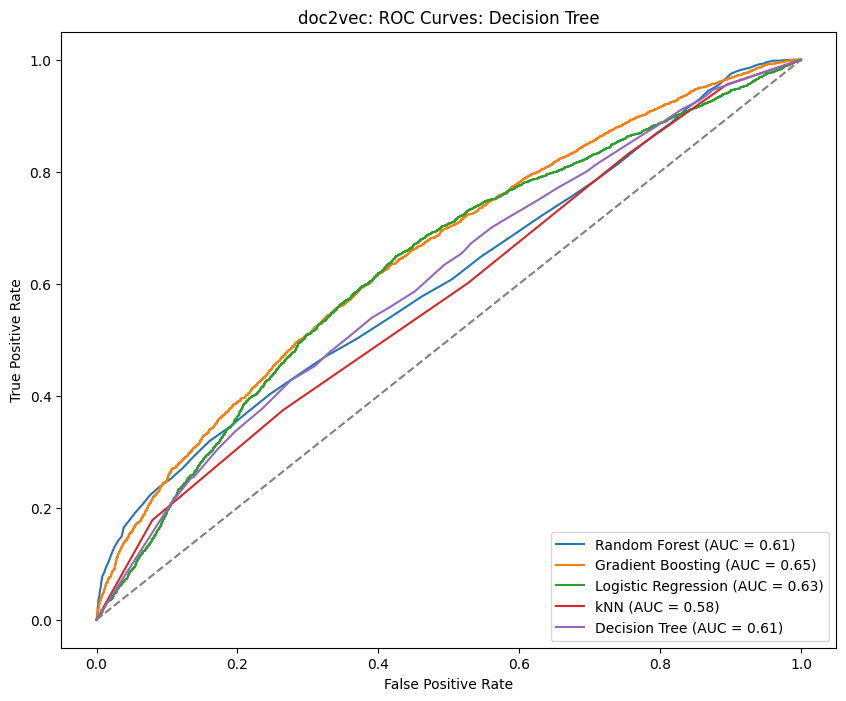

Random Forest - Accuracy: 0.5636, AUC: 0.6136, F1: 0.6147
Gradient Boosting - Accuracy: 0.6159, AUC: 0.6658, F1: 0.6735
Logistic Regression - Accuracy: 0.6134, AUC: 0.6648, F1: 0.6634
kNN - Accuracy: 0.5460, AUC: 0.5828, F1: 0.5885
Decision Tree - Accuracy: 0.5763, AUC: 0.6114, F1: 0.5780

word2vec: Best Model: Gradient Boosting (AUC = 0.6658)


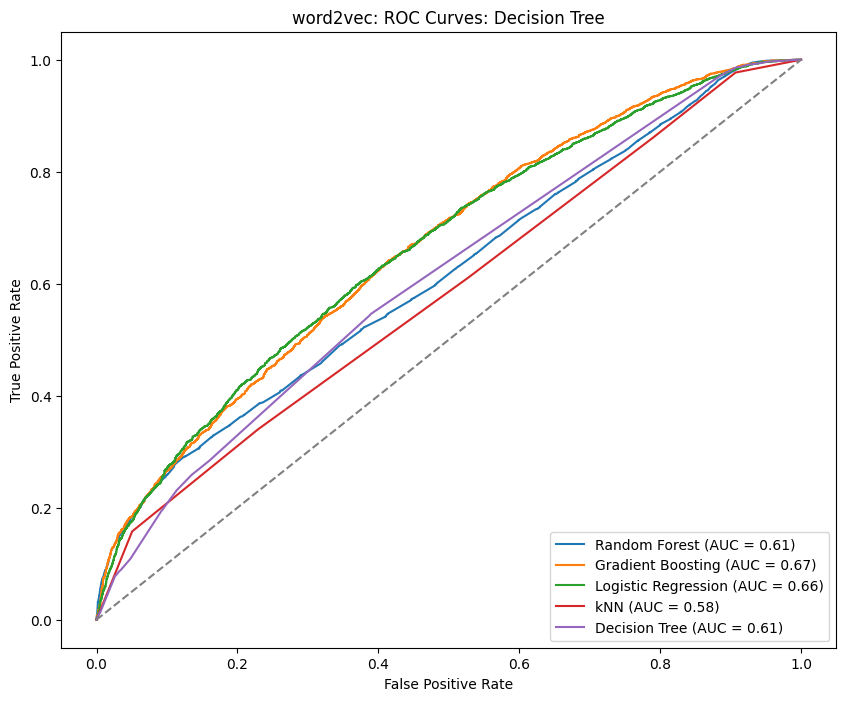

Random Forest - Accuracy: 0.5968, AUC: 0.6318, F1: 0.6509
Gradient Boosting - Accuracy: 0.6445, AUC: 0.6976, F1: 0.6947
Logistic Regression - Accuracy: 0.6571, AUC: 0.7104, F1: 0.6947
kNN - Accuracy: 0.5795, AUC: 0.6313, F1: 0.6318
Decision Tree - Accuracy: 0.5763, AUC: 0.6081, F1: 0.6497

bert: Best Model: Logistic Regression (AUC = 0.7104)


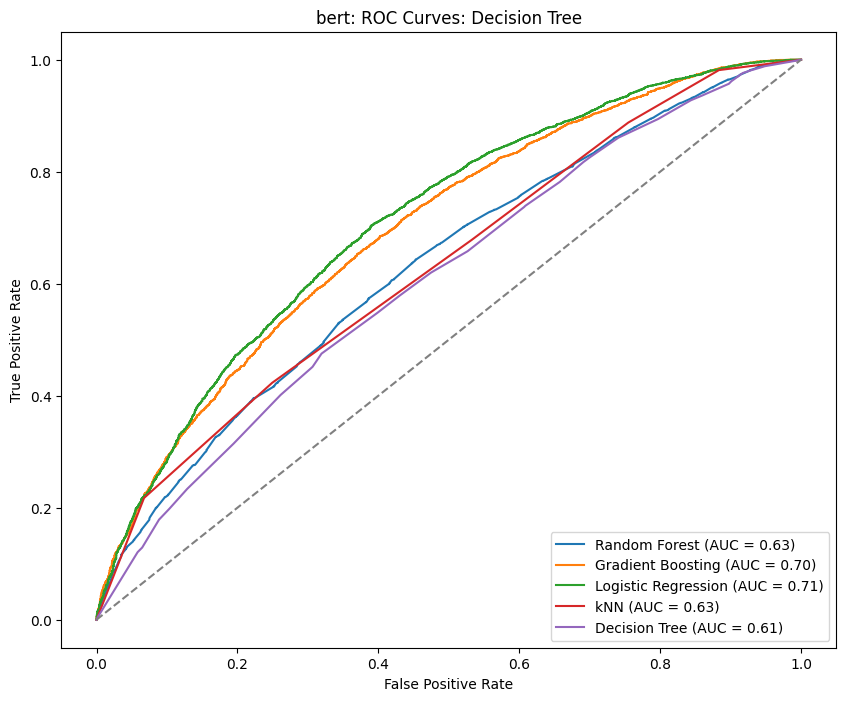

NameError: name 'elmo_embeddings' is not defined

In [ ]:
# TFIDF Matrix
tfidf_model, tfidf_f1, tfidf_fpr, tfidf_tpr = classification_model('TFIDF', TFIDF_embeddings, data['label'])

# doc2vec
doc2vec_model, doc2vec_f1, doc2vec_fpr, doc2vec_tpr =  classification_model('doc2vec', doc2vec_embeddings, data['label'])

# word2vec
word2vec_model, word2vec_f1, word2vec_fpr, word2vec_tpr =  classification_model('word2vec', word2vec_embeddings, data['label'])

# Bert embeddings
bert_model, bert_f1, bert_fpr, bert_tpr = classification_model('bert', bert_embeddings, data['label'])


Random Forest - Accuracy: 0.5126, AUC: 0.4998, F1: 0.5942
Gradient Boosting - Accuracy: 0.5276, AUC: 0.5201, F1: 0.6631
Logistic Regression - Accuracy: 0.5174, AUC: 0.5039, F1: 0.6494
kNN - Accuracy: 0.5037, AUC: 0.5028, F1: 0.5492
Decision Tree - Accuracy: 0.5267, AUC: 0.5171, F1: 0.6520

elmo: Best Model: Gradient Boosting (AUC = 0.5201)


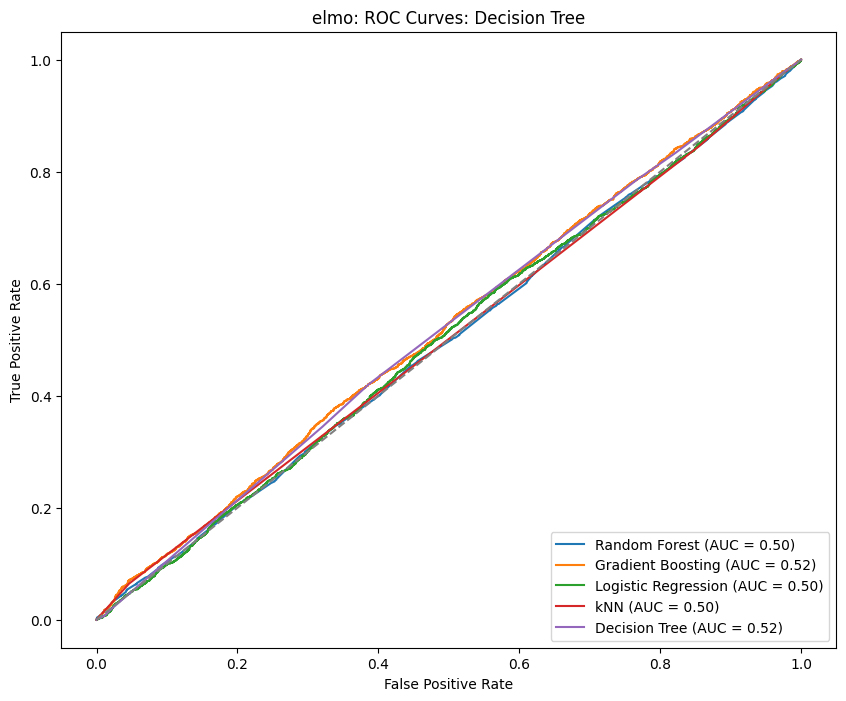

In [52]:
# elmo embeddings
elmo_model, elmo_f1, elmo_fpr, elmo_tpr = classification_model('elmo', elmo_embeddings, data['label'])

# Classify New Text

In [59]:
new_data = pd.read_excel('/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data/new_hate_df.xlsx')

new_data

,Hateful?,Comment
0,N,Nobody will care. Nobody watches that shit. Qu...
1,N,I see your treasonous bitch ass wants to get s...
2,N,You’re proud of voting for the guy tanking our...
3,N,Listen up Cheeto Corleone: You run America lik...
4,N,terrible policy changes
5,P,Who cares?? You're so America first absolutist...
6,N,You were my preferred airline. There is offici...
7,P,"You, girly named dude, woman abusing supporter..."
8,P,lets kill jews and eat them for fun


/var/folders/zv/4f9cw9vs6tjbvz5bh2k07w_40000gn/T/ipykernel_85442/2275907299.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


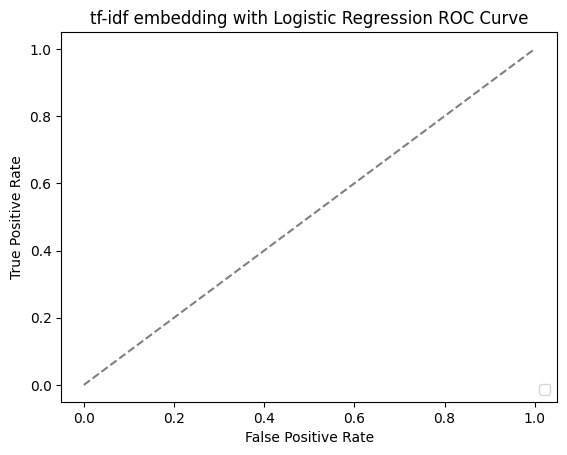

In [74]:
new_data = pd.read_excel('/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data/new_hate_df.xlsx')

# clean comment
new_data['cleaned_comment'] = new_data['Comment'].apply(clean_comment)
new_data['cleaned_comment_string'] = new_data['cleaned_comment'].apply(lambda x: " ".join(x))

# fit on training data
Tfidf = TfidfVectorizer(ngram_range=(1, 1))
TFIDF_embeddings = Tfidf.fit_transform(data['cleaned_comment_string'].tolist())

# now apply same vectorizor to new test data
TFIDF_embeddings_new = Tfidf.transform(new_data['cleaned_comment_string'].tolist())


# ClUSTER
#cluster_embeddings("tfidf", TFIDF_embeddings_new, n_clusters=2)

def convert_labels(label):
    if label == 'N':
        return 1
    else:
        return 0
    
X_train = TFIDF_embeddings
Y_train = data['label']
Y_train = Y_train.apply(convert_labels)

X_test = TFIDF_embeddings_new
y_test = new_data['Hateful?'].apply(convert_labels)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, Y_train)

# predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Plot ROC curves
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.title(f"tf-idf embedding with Logistic Regression ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()




In [76]:
y_pred

array([0, 1, 0, 0, 0, 1, 0, 1, 1])

In [77]:
new_data

,Hateful?,Comment,cleaned_comment,cleaned_comment_string
0,N,Nobody will care. Nobody watches that shit. Qu...,"[nobodi, care, nobodi, watch, shit, quit, pret...",nobodi care nobodi watch shit quit pretend dont
1,N,I see your treasonous bitch ass wants to get s...,"[see, treason, bitch, ass, want, get, click, l...",see treason bitch ass want get click let right...
2,N,You’re proud of voting for the guy tanking our...,"[proud, vote, guy, tank, economi, alien, alli,...",proud vote guy tank economi alien alli caus su...
3,N,Listen up Cheeto Corleone: You run America lik...,"[listen, cheeto, corleon, run, america, like, ...",listen cheeto corleon run america like bit mob...
4,N,terrible policy changes,"[terribl, polici, chang]",terribl polici chang
5,P,Who cares?? You're so America first absolutist...,"[care, your, america, first, absolutist, youd,...",care your america first absolutist youd root h...
6,N,You were my preferred airline. There is offici...,"[prefer, airlin, offici, zero, reason, fli, fa...",prefer airlin offici zero reason fli fare expe...
7,P,"You, girly named dude, woman abusing supporter...","[girli, name, dude, woman, abus, support, advo...",girli name dude woman abus support advoc retard
8,P,lets kill jews and eat them for fun,"[let, kill, jew, eat, fun]",let kill jew eat fun
